In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv

from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist


import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from collections import defaultdict

In [22]:
#Data load and feature engineering

df = pd.read_csv('./data/DATA.csv')

df.drop(columns = ['time_signature'], inplace = True)

# Drop rows containing null values as they aren't a significant number
df.dropna(inplace = True)
# Drop duplicate songs
df.drop_duplicates(['id'], inplace = True)

#change release_date to datetime
df['release_year'] = df['release_date'].apply(lambda x: x.split('-')[0])
df.drop(columns = ['release_date'], inplace = True)

#Change duration in ms to seconds and drop duration_ms column
df['duration'] = df['duration_ms'].apply(lambda x: round(x/1000))
df.drop(columns = ['duration_ms'], inplace = True)

df.head(1)

,id,title,all_artists,popularity,danceability,energy,key,loudness,mode,acousticness,instrumentalness,liveness,valence,tempo,release_year,duration
0,6sxptembJVty4sNtcPMAVz,Man! I Feel Like A Woman!,Shania Twain,75,0.657,0.639,10,-7.527,1,0.581,0.0,0.278,0.674,124.882,1997,234


In [23]:
#Scaling Data.

df_numerical = df.select_dtypes(np.number)

scaler = StandardScaler().fit(df_numerical) #Only Scale numerical columns
scaled_data = scaler.transform(df_numerical)

features_df = pd.DataFrame(scaled_data)
features_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.293845,0.187056,0.241786,1.286731,0.329962,0.816176,0.672746,-0.515410,0.710374,0.594546,0.285581,0.144366
1,1.053106,0.491779,-0.188464,-0.105292,-0.459721,0.816176,-0.840558,-0.515400,-0.963114,0.655146,-0.191937,-0.312777
2,1.293845,-0.428366,0.780533,0.173113,0.588457,0.816176,0.197950,-0.515405,3.162600,1.121004,-0.409030,-0.853038
3,1.213598,0.270705,-0.274514,-0.383696,-0.533025,0.816176,-0.014989,-0.515410,0.126842,1.299014,-1.062945,-0.118838
4,1.213598,-0.966113,0.892772,1.286731,0.537067,0.816176,-0.955085,-0.515410,0.543650,-0.007660,-1.457183,-0.008015


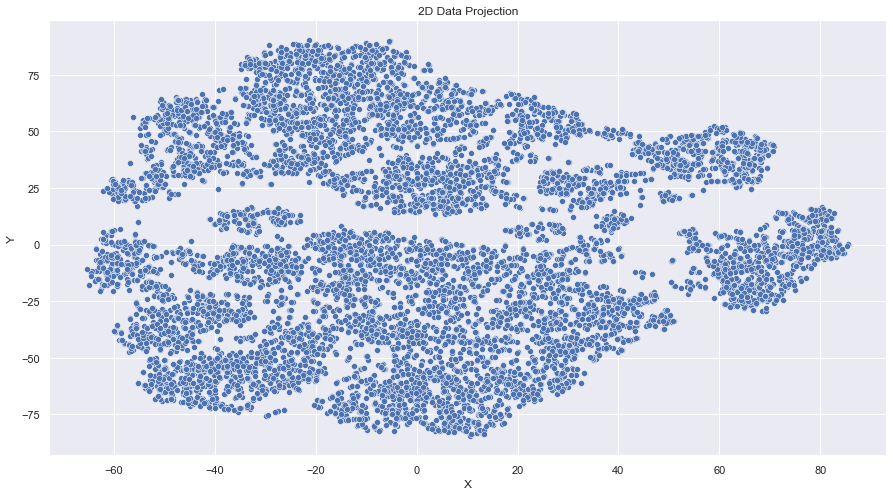

In [24]:
#Instantiating TSNE
tsne = TSNE(n_components=2, random_state=42)


tsne_df = pd.DataFrame(tsne.fit_transform(scaled_data), columns = ['X', 'Y'] )

sns.set(rc = {'figure.figsize':(15,8)})
sns.scatterplot(x= 'X', y= 'Y',data= tsne_df).set(title= '2D Data Projection');

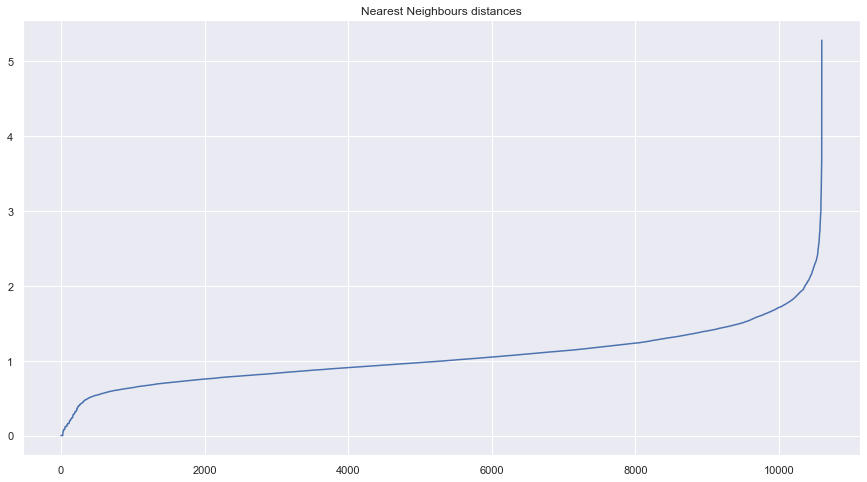

In [5]:

nn = NearestNeighbors(n_neighbors=2)
neihbors = nn.fit(features_df)
distances, indices = neihbors.kneighbors(features_df)

#Next, we sort and plot results
distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.figure(figsize=(15, 8))
plt.plot(distances)
plt.title('Nearest Neighbours distances');

In [6]:
# Compute DBSCAN looking for the best "eps" value
for i in range(18, 30, 1):
    eps = i/10
    db = DBSCAN(eps = eps).fit(features_df)
    labels = db.labels_
    number_clusters = len(np.unique(labels))
    if number_clusters > 1:
        print(f'Eps={eps}: est_clusters = {number_clusters}    silhouette_score = {silhouette_score(features_df, labels)}    davies_bouldin_score = {davies_bouldin_score(features_df, labels)}')
    else:
        print(f'Eps={eps}: {number_clusters}, NO scores')

Eps=1.8: est_clusters = 7    silhouette_score = 0.0184799085561642    davies_bouldin_score = 2.0177110431703165
Eps=1.9: est_clusters = 6    silhouette_score = 0.02598975640577035    davies_bouldin_score = 2.14230243148856
Eps=2.0: est_clusters = 3    silhouette_score = 0.10374181373080991    davies_bouldin_score = 2.856648050313172
Eps=2.1: est_clusters = 2    silhouette_score = 0.2810994651583852    davies_bouldin_score = 2.603489399939555
Eps=2.2: est_clusters = 2    silhouette_score = 0.31316995244142076    davies_bouldin_score = 2.3163794133119566
Eps=2.3: est_clusters = 2    silhouette_score = 0.3336600591754627    davies_bouldin_score = 2.15627905639869
Eps=2.4: est_clusters = 2    silhouette_score = 0.36874732585007525    davies_bouldin_score = 1.8604769657704958
Eps=2.5: est_clusters = 3    silhouette_score = 0.3663966275458842    davies_bouldin_score = 1.6631352560496788
Eps=2.6: est_clusters = 4    silhouette_score = 0.3096653623384838    davies_bouldin_score = 1.94280232269

In [20]:
# Plotting DBSCAN choosing eps = 2.5 as it is where a significant improvement from the scores occurs.

db = DBSCAN(eps = 2.5).fit(features_df)

tsne_df['cluster'] = pd.Categorical(db.labels_) #Categorical class classifies by unique values

sns.set(rc = {'figure.figsize':(15,8)})
sns.scatterplot(x='X', y='Y', hue='cluster', style='cluster', data= tsne_df, legend=None).set(title= 'DBSCAN with eps=2.5');

TypeError: Feature names are only supported if all input features have string names, but your input has ['int', 'str'] as feature name / column name types. If you want feature names to be stored and validated, you must convert them all to strings, by using X.columns = X.columns.astype(str) for example. Otherwise you can remove feature / column names from your input data, or convert them all to a non-string data type.

/Users/santiaguilar/opt/anaconda3/envs/ironhack/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/santiaguilar/opt/anaconda3/envs/ironhack/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/santiaguilar/opt/anaconda3/envs/ironhack/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/santiaguilar/opt/anaconda3/envs/ironhack/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Se

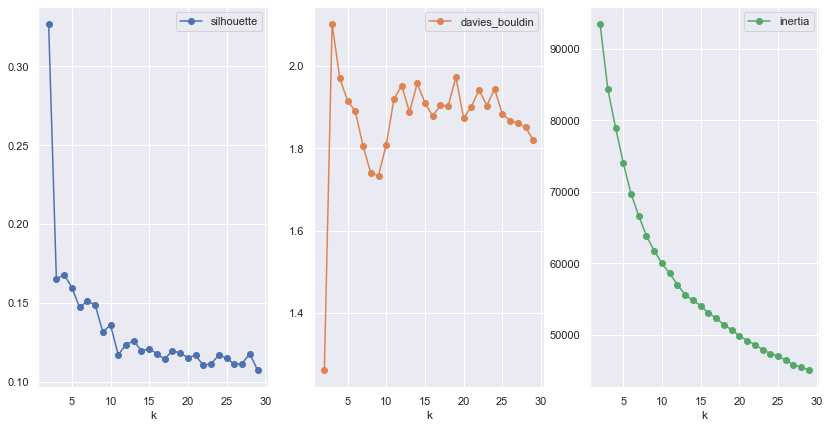

In [8]:
# Plot K-Means scores 

scores = []
for k in range(2,30):
    km = KMeans(n_clusters = k).fit(features_df)
    labels = km.labels_
    inertia = km.inertia_

    silhouette = silhouette_score(features_df, labels)
    davies_bouldin = davies_bouldin_score(features_df, labels)
    scores.append([k, silhouette, davies_bouldin, inertia])
    
score_df = pd.DataFrame(scores, columns=['k', 'silhouette', 'davies_bouldin', 'inertia'])
axs = score_df.plot(x='k', subplots=True, layout=(1,3), figsize=(14,7), marker='o')

In [9]:
# Compute K-Means looking for the best "k" value

best_k = 0
best_sil = 0 #we are going to determine the best k with silhouette_score as an indicator
best_dav = 100 #To initialize and keep saving always the lowest
for k in range(3,30): #starting at 3 because of graph telling us that 2 is going to mess up the exploration
    km = KMeans(n_clusters = k).fit(features_df)
    labels = km.labels_
    number_clusters = len(np.unique(labels))
    if number_clusters > 1:
        if davies_bouldin_score(features_df, labels) < best_dav:
            print(f'Clusters = {number_clusters} and silhouette_score = {silhouette_score(features_df, labels)} and davies_bouldin_score = {davies_bouldin_score(features_df, labels)}')
            best_k = k
            best_sil = silhouette_score(features_df, labels)
            best_dav = davies_bouldin_score(features_df, labels)
            
print(f'Best k={best_k}')
print(f'Best silhouette_score={best_sil}')
print(f'Best davies_bouldin_score={best_dav}')

/Users/santiaguilar/opt/anaconda3/envs/ironhack/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Clusters = 3 and silhouette_score = 0.16501907252240486 and davies_bouldin_score = 2.102022145927213


/Users/santiaguilar/opt/anaconda3/envs/ironhack/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Clusters = 4 and silhouette_score = 0.15312853993263276 and davies_bouldin_score = 2.0868533752781095


/Users/santiaguilar/opt/anaconda3/envs/ironhack/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Clusters = 5 and silhouette_score = 0.15134446611802074 and davies_bouldin_score = 1.9985774449509475


/Users/santiaguilar/opt/anaconda3/envs/ironhack/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Clusters = 6 and silhouette_score = 0.14708503126077888 and davies_bouldin_score = 1.8907341985817971


/Users/santiaguilar/opt/anaconda3/envs/ironhack/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Clusters = 7 and silhouette_score = 0.1511516017891743 and davies_bouldin_score = 1.8051708758603413


/Users/santiaguilar/opt/anaconda3/envs/ironhack/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Clusters = 8 and silhouette_score = 0.14887408443979502 and davies_bouldin_score = 1.7402416647779768


/Users/santiaguilar/opt/anaconda3/envs/ironhack/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Clusters = 9 and silhouette_score = 0.13196679366537634 and davies_bouldin_score = 1.7339801009853866


/Users/santiaguilar/opt/anaconda3/envs/ironhack/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/santiaguilar/opt/anaconda3/envs/ironhack/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/santiaguilar/opt/anaconda3/envs/ironhack/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/santiaguilar/opt/anaconda3/envs/ironhack/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Se

Best k=9
Best silhouette_score=0.13196679366537634
Best davies_bouldin_score=1.7339801009853866


In [10]:
print(features_df.shape)
features_df.head()

(10595, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
0,1.293845,0.187056,0.241786,1.286731,0.329962,0.816176,0.672746,-0.515410,0.710374,0.594546,0.285581,0.144366
1,1.053106,0.491779,-0.188464,-0.105292,-0.459721,0.816176,-0.840558,-0.515400,-0.963114,0.655146,-0.191937,-0.312777
2,1.293845,-0.428366,0.780533,0.173113,0.588457,0.816176,0.197950,-0.515405,3.162600,1.121004,-0.409030,-0.853038
3,1.213598,0.270705,-0.274514,-0.383696,-0.533025,0.816176,-0.014989,-0.515410,0.126842,1.299014,-1.062945,-0.118838
4,1.213598,-0.966113,0.892772,1.286731,0.537067,0.816176,-0.955085,-0.515410,0.543650,-0.007660,-1.457183,-0.008015


/Users/santiaguilar/opt/anaconda3/envs/ironhack/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


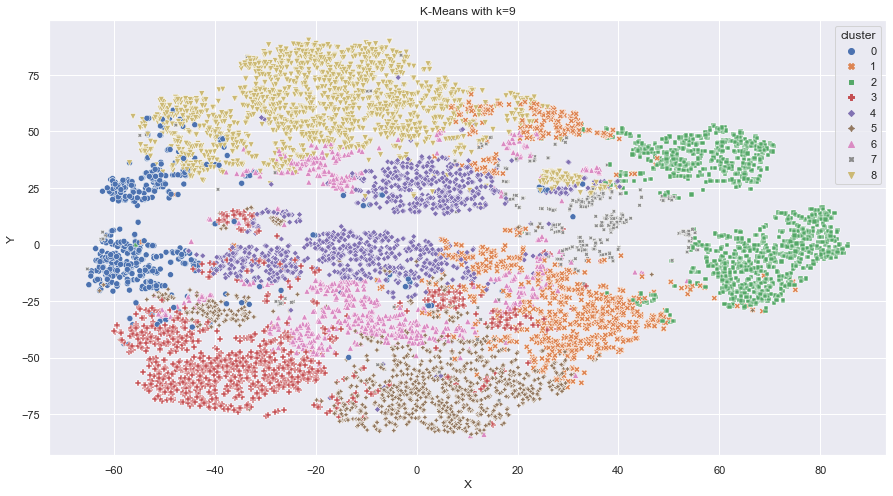

In [11]:
# Plotting K-Means k=9
km = KMeans(n_clusters = 9).fit(features_df)
tsne_df['cluster'] = pd.Categorical(km.labels_)

sns.set(rc = {'figure.figsize':(15,8)})
sns.scatterplot(x='X', y='Y', hue='cluster', style='cluster', data= tsne_df).set(title= 'K-Means with k=9');

In [16]:
load_dotenv()

True

In [19]:
client_id = os.getenv("client_id")
client_secret = os.getenv("client_secret")

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=client_id, client_secret=client_secret))

def find_song(lista):
    inp = pd.DataFrame() 
    for (title, artist) in lista:
        song_data = defaultdict()
        
        results = sp.search(q = 'track: {} artist: {}'.format(title, artist), limit=1, offset=0, type='track')
        if results['tracks']['items'] == []:
            return None

        results = results['tracks']['items'][0]
        track_id = results['id']
        audio_features = sp.audio_features(track_id)[0]

        song_data['title'] = [title]
        song_data['artist'] = [artist]
        song_data['duration_ms'] = [results['duration_ms']]
        song_data['popularity'] = [results['popularity']]

        for key, value in audio_features.items():
        
            song_data[key] = value
    
        df = pd.DataFrame(song_data)
    
        #CAMBIOS DE MI FEATURE ENGINEERING    
        df.drop(columns = ['time_signature'], inplace = True)

        # Drop rows containing null values as they aren't a significant number
        df.dropna(inplace = True)
        df.drop_duplicates(['id'], inplace = True)

        #Change duration in ms to seconds and drop duration_ms column
        df['duration'] = df['duration_ms'].apply(lambda x: round(x/1000))
        df.drop(columns = ['duration_ms'], inplace = True)
        inp = pd.concat([inp, df])
    return inp


list_of_songs = []
while len(list_of_songs)<2:
    input_song = input('Enter song name:')
    input_artist = input('Enter artist name:')
    list_of_songs.append((input_song, input_artist))

y = find_song(list_of_songs)


y.drop(columns = ['speechiness'], inplace = True)
y = y.select_dtypes(np.number).mean()

scaled_y = scaler.transform(np.array(y).reshape(1,-1))

def recommend_songs(feats_df, track_data, y, n):
    
    feats_df['cluster'] = pd.Categorical(km.labels_)
    user_cluster = km.predict(y)
    
    df_slice = feats_df[feats_df['cluster']==user_cluster[0]]
    df_slice = df_slice.drop(['cluster'], axis=1)
    indices = feats_df[feats_df['cluster']==user_cluster[0]].reset_index()['index'].to_numpy()
    
    scaled_data = df_slice.to_numpy()
    
    simi = cdist(scaled_data, y, metric='cosine').argsort(axis=None)[:n]

    rec_songs = track_data.iloc[simi]
    
    return rec_songs[['title', 'all_artists']]

recommend_songs(feats_df = features_df , track_data = df, y = scaled_y, n = 10)

/Users/santiaguilar/opt/anaconda3/envs/ironhack/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


,title,all_artists
563,Run - Edit,George Strait
240,Confession,Florida Georgia Line
334,Amos Moses,Jerry Reed
544,Take Me,Tammy Wynette
341,The General Lee,Johnny Cash
1019,Tuesday's Gone,"Hank Williams, Jr."
993,Now That the Magic Has Gone,Joe Cocker
328,Hurt,Johnny Cash
226,Up All Night,Jon Pardi
835,Big Iron,Colter Wall
